In [1]:
%load_ext autoreload
%autoreload 2
from matplotlib import pyplot as plt
import mujoco
from mujoco import mjx
import jax
import pickle
import numpy as np
from dm_control import mjcf
from dm_control.locomotion.walkers import rescale
import utils
import controller as ctrl
import operations as op
from jax import numpy as jnp
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

model_xml = "../models/rodent_stac_optimized.xml"
params_path = "../params/params.yaml"
utils.init_params(params_path)

data_path = "../transform_fast_snips.p"

### set up mj model -- stepping in mjx so we can do batch processing

In [2]:
# Load mjx_model and mjx_data and set marker sites
root = mjcf.from_path(model_xml)
physics, mj_model = ctrl.create_body_sites(root)
# physics, mj_model, keypoint_sites = ctrl.create_keypoint_sites(root)

rescale.rescale_subtree(
    root,
    utils.params["SCALE_FACTOR"],
    utils.params["SCALE_FACTOR"],
)

# Load data
with open(data_path, "rb") as file:
    d = pickle.load(file)
    qposes = np.array(d["qpos"])
    kp_data = np.array(d["kp_data"])
    offsets = np.array(d['offsets'])

# slice kp_data to match qposes length
kp_data = kp_data[:qposes.shape[0]]

In [3]:
def resid(mjx_model, mjx_data, qpos, kps):
    mjx_data = mjx_data.replace(qpos=qpos)
    # Forward kinematics
    mjx_data = op.kinematics(mjx_model, mjx_data)
    mjx_data = op.com_pos(mjx_model, mjx_data)
    # get marker positions
    markers = op.get_site_xpos(mjx_data).flatten()
    # Return the summed squared error
    return jnp.sum(jnp.square((kps - markers)))

In [4]:
@jax.vmap
def batch_init(batch_qposes):
    mjx_model = mjx.put_model(mj_model)
    mjx_model = op.set_site_pos(mjx_model, jnp.reshape(offsets, (-1, 3))) 
    mjx_data = mjx.make_data(mjx_model)
    return mjx_model, mjx_data

In [8]:
# reshape qposes and kp_data such that it is shape: (n, b, x)
# n = iterations, b = batchsize, x = dims of the data
clip_len = 250
n = qposes.shape[0]//clip_len

batch_qposes = qposes.reshape(n,clip_len,74)
batch_kps = kp_data.reshape(n,clip_len,69)

batch_qposes.shape, batch_kps.shape

((842, 250, 74), (842, 250, 69))

In [9]:
mjx_model, mjx_data = batch_init(batch_qposes)
jit_vmap_resid = jax.jit(jax.vmap(resid))

In [10]:
errors = []
# render while stepping using mujoco
for i in range(clip_len):
    if i%50 == 0:
        print(f"{i}")
    qpos = batch_qposes[:, i, :]
    kps = batch_kps[:, i, :]
    # Calculate squared error btwn offsets and keypoints
    errors.append(jit_vmap_resid(mjx_model, mjx_data, qpos, kps))

errors = np.array(errors)
errors = errors.ravel(order="F")
# Save it as .npy file
np.save("../offset_errors/errors_" + data_path[3:-2] + ".npy", errors)

0
50
100
150
200


## Plots below

In [11]:
# errors = np.load("../offset_errors/errors_transform_random_1k_12_21_1.npy")

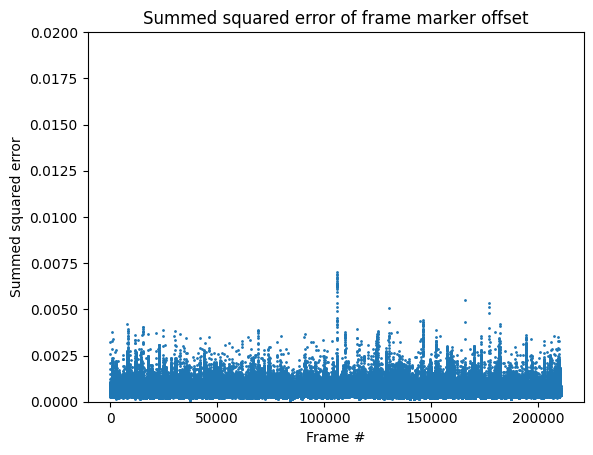

In [13]:
plt.ylim(0, 0.02)
plt.title("Summed squared error of frame marker offset")
plt.xlabel("Frame #")
plt.ylabel("Summed squared error")
x = qposes.shape[0]
plt.scatter(np.arange(x),errors[:x], s=1)

In [14]:
print(f"mean: {errors.mean()}, std: {errors.std()}")

mean: 0.0006663730600848794, std: 0.0003662412927951664


In [17]:
cutoff = x
indices = np.where(errors[:cutoff] > 0.005)[0]

print(f"there are {indices.shape[0]} not good offset frames before the cutoff at {cutoff}")

there are 25 not good offset frames before the cutoff at 210500


(array([0.0000e+00, 5.6500e+02, 1.2399e+04, 3.1850e+04, 3.6771e+04,
        3.1041e+04, 2.4616e+04, 1.9047e+04, 1.4466e+04, 1.0917e+04,
        7.7690e+03, 5.5250e+03, 3.8530e+03, 2.7210e+03, 1.9720e+03,
        1.5830e+03, 1.1590e+03, 8.7600e+02, 7.4300e+02, 5.9100e+02,
        4.7300e+02, 3.4400e+02, 2.1600e+02, 1.6900e+02, 1.5000e+02,
        1.0700e+02, 1.0900e+02, 7.5000e+01, 6.5000e+01, 5.3000e+01,
        3.7000e+01, 2.8000e+01, 3.4000e+01, 2.3000e+01, 2.8000e+01,
        2.3000e+01, 1.7000e+01, 1.3000e+01, 1.5000e+01, 6.0000e+00,
        5.0000e+00, 5.0000e+00, 5.0000e+00, 7.0000e+00, 1.0000e+00,
        1.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 1.0000e+00,
        1.0000e+00, 2.0000e+00, 0.0000e+00, 2.0000e+00, 0.0000e+00,
        1.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00,
        0.0000e+00, 2.0000e+00, 4.0000e+00, 3.0000e+00, 1.0000e+00,
        1.0000e+00, 2.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
        1.0000e+00, 0.0000e+00, 0.0000e+00, 0.00

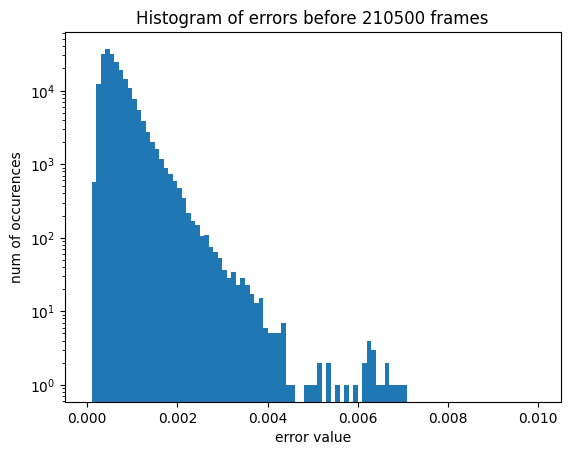

In [18]:
# plot graph where x = error value and y = number of frames in log scale
plt.title(f"Histogram of errors before {cutoff} frames")
plt.xlabel("error value")
plt.ylabel("num of occurences")
plt.hist(errors[:cutoff], bins=100, range=(0,0.01), log=True)


In [19]:
# Plot a histogram where the values are hte change in qpos from previous to current frame
# Load data
with open(data_path, "rb") as file:
    d = pickle.load(file)
    qposes = np.array(d["qpos"])

qpos_diff = np.diff(qposes, axis=0)

In [20]:
qpos_diff_summed = np.abs(qpos_diff).sum(axis=1)
qpos_diff_summed.shape

(210499,)

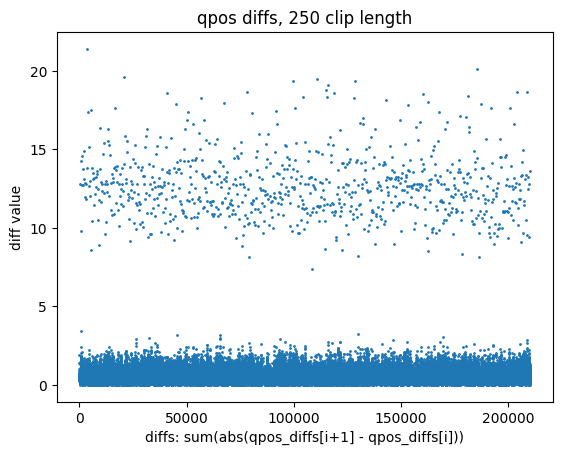

In [21]:
plt.title(f"qpos diffs, {clip_len} clip length")
plt.xlabel("diffs: sum(abs(qpos_diffs[i+1] - qpos_diffs[i]))")
plt.ylabel("diff value")
plt.scatter(np.arange(cutoff-1), qpos_diff_summed[:cutoff], s=1)

In [23]:
# Split qpos_diff_summed into two arrays: one has 10 values for every multiple of 360, 
# and the other one has the rest of the values
# This is to see if the diffs statistics are different between the two
mask = np.array([(i+1)%clip_len <= 5 for i in range(cutoff-1)])
qpos_diff_summed_360 = qpos_diff_summed[:cutoff][mask]
qpos_diff_summed_360.shape

(5051,)

(array([2.000e+01, 4.710e+02, 1.480e+03, 1.081e+03, 6.440e+02, 3.110e+02,
        1.060e+02, 7.400e+01, 2.000e+01, 3.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00,
        0.000e+00, 0.000e+00, 3.000e+00, 1.000e+00, 4.000e+00, 5.000e+00,
        4.000e+00, 8.000e+00, 1.700e+01, 1.700e+01, 2.200e+01, 2.400e+01,
        2.300e+01, 3.500e+01, 4.600e+01, 3.600e+01, 5.200e+01, 4.200e+01,
        3.600e+01, 4.300e+01, 4.900e+01, 6.100e+01, 4.700e+01, 3.000e+01,
        3.200e+01, 2.800e+01, 2.700e+01, 2.300e+01, 1.300e+01, 1.200e+01,
        1.200e+01, 1.300e+01, 9.000e+00, 6.000e+00, 4.000e+00, 8.000e+00,
        6.000e+00, 5.000e+00, 2.000e+00, 5.000e+00, 5.000e+00, 4.000e+00,
        3.000e+00, 4.000e+00, 6.000e+00, 1.000e+00, 1.000e+00, 3.000e+00,
        1.000e+00, 0.000e+00, 1.000e+0

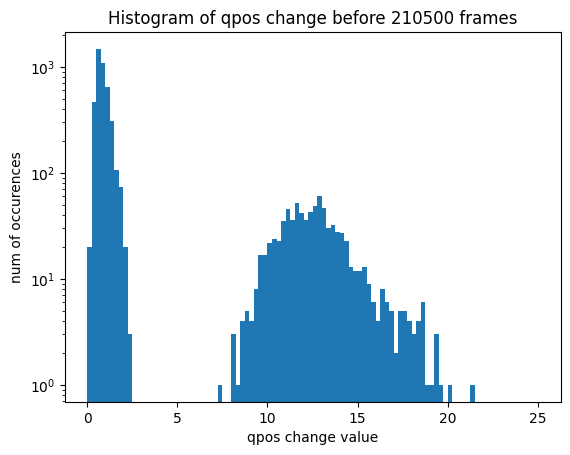

In [24]:
# plot graph where x = error value and y = number of frames in log scale
plt.title(f"Histogram of qpos change before {cutoff} frames")
plt.xlabel("qpos change value")
plt.ylabel("num of occurences")
plt.hist(qpos_diff_summed_360, bins=100, range=(0,25), log=True)

(205448,)


(array([8.2268e+04, 6.7852e+04, 3.0912e+04, 1.4721e+04, 6.1990e+03,
        2.2260e+03, 7.6500e+02, 3.1400e+02, 1.0700e+02, 5.1000e+01,
        2.1000e+01, 7.0000e+00, 4.0000e+00, 1.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.00

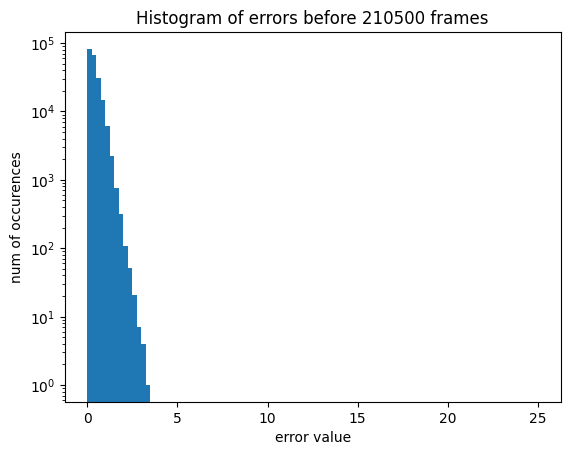

In [29]:
mask = np.array([(i+1)%clip_len > 5 for i in range(cutoff-1)])
qpos_diff_summed_mid = qpos_diff_summed[:cutoff][mask]
print(qpos_diff_summed_mid.shape)
# plot graph where x = error value and y = number of frames in log scale
plt.title(f"Histogram of errors before {cutoff} frames")
plt.xlabel("error value")
plt.ylabel("num of occurences")
plt.hist(qpos_diff_summed_mid, bins=100, range=(0,25), log=True)

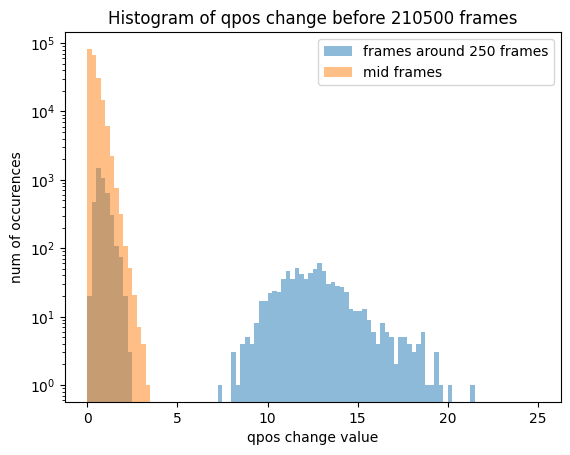

In [30]:
# Overlay the above two histograms 
plt.title(f"Histogram of qpos change before {cutoff} frames")
plt.xlabel("qpos change value")
plt.ylabel("num of occurences")
plt.hist(qpos_diff_summed_360, bins=100, range=(0,25), log=True, alpha=0.5, label=f"frames around {clip_len} frames")
plt.hist(qpos_diff_summed_mid, bins=100, range=(0,25), log=True, alpha=0.5, label="mid frames")
plt.legend()


# view select frame where we have high error

In [31]:
indices[:100]

array([105948, 105949, 105950, 105951, 105952, 105953, 105954, 105955,
       105956, 105957, 105958, 105959, 105960, 105961, 105962, 105963,
       105964, 105965, 105966, 105967, 105968, 130073, 165500, 176907,
       176908])

In [32]:
import mediapy as media
from dm_control.mujoco.wrapper.mjbindings import enums
root = mjcf.from_path(model_xml)
physics, mj_model = ctrl.create_body_sites(root)
physics, mj_model, keypoint_sites = ctrl.create_keypoint_sites(root)
renderer = mujoco.Renderer(mj_model)
mj_data = mujoco.MjData(mj_model)
scene_option = mujoco.MjvOption()
scene_option.geomgroup[2] = 1
scene_option.sitegroup[2] = 1

scene_option.sitegroup[3] = 1
scene_option.flags[enums.mjtVisFlag.mjVIS_TRANSPARENT] = True
scene_option.flags[enums.mjtVisFlag.mjVIS_LIGHT] = False
scene_option.flags[enums.mjtVisFlag.mjVIS_CONVEXHULL] = True
scene_option.flags[enums.mjtRndFlag.mjRND_SHADOW] = False
scene_option.flags[enums.mjtRndFlag.mjRND_REFLECTION] = False
scene_option.flags[enums.mjtRndFlag.mjRND_SKYBOX] = False
scene_option.flags[enums.mjtRndFlag.mjRND_FOG] = False

""

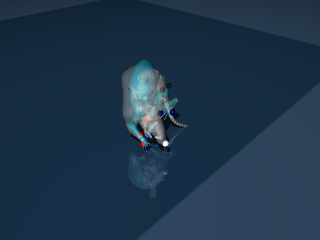

In [33]:
index = indices[0]
mj_data.qpos = qposes[index]
physics, mj_model = ctrl.set_keypoint_sites(physics, keypoint_sites, kp_data[index])
mujoco.mj_forward(mj_model, mj_data)
renderer.update_scene(mj_data, camera="close_profile", scene_option=scene_option)

media.show_image(renderer.render())